Training fold 1...
Found 2016 validated image filenames belonging to 3 classes.
Found 126 validated image filenames belonging to 3 classes.
Epoch 1/100
63/63 [==============================] - 2s 21ms/step - loss: 0.8343 - accuracy: 0.6205 - precision: 0.6909 - recall: 0.4534 - f1_score: 0.5073 - val_loss: 0.9012 - val_accuracy: 0.5397 - val_precision: 0.5976 - val_recall: 0.3889 - val_f1_score: 0.2337
Epoch 2/100
63/63 [==============================] - 1s 16ms/step - loss: 0.4172 - accuracy: 0.8438 - precision: 0.8728 - recall: 0.8170 - f1_score: 0.8289 - val_loss: 0.4128 - val_accuracy: 0.8651 - val_precision: 0.8824 - val_recall: 0.8333 - val_f1_score: 0.3092
Epoch 3/100
63/63 [==============================] - 1s 16ms/step - loss: 0.2234 - accuracy: 0.9271 - precision: 0.9361 - recall: 0.9162 - f1_score: 0.9196 - val_loss: 0.3881 - val_accuracy: 0.8333 - val_precision: 0.8443 - val_recall: 0.8175 - val_f1_score: 0.3030
Epoch 4/100
63/63 [==============================] - 1s 15ms/s

c:\Users\mitja\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1350/1350 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00
Test Results: [0.0, 0.0, 0.0, 0.0, 0.0]
1350/1350 [==============================] - 3s 2ms/step
Povprečne vrednosti metrik:
loss: 0.019716132535696488
accuracy: 0.9926001986265183
val_loss: 0.5746257385164499
val_accuracy: 0.9097142767310141


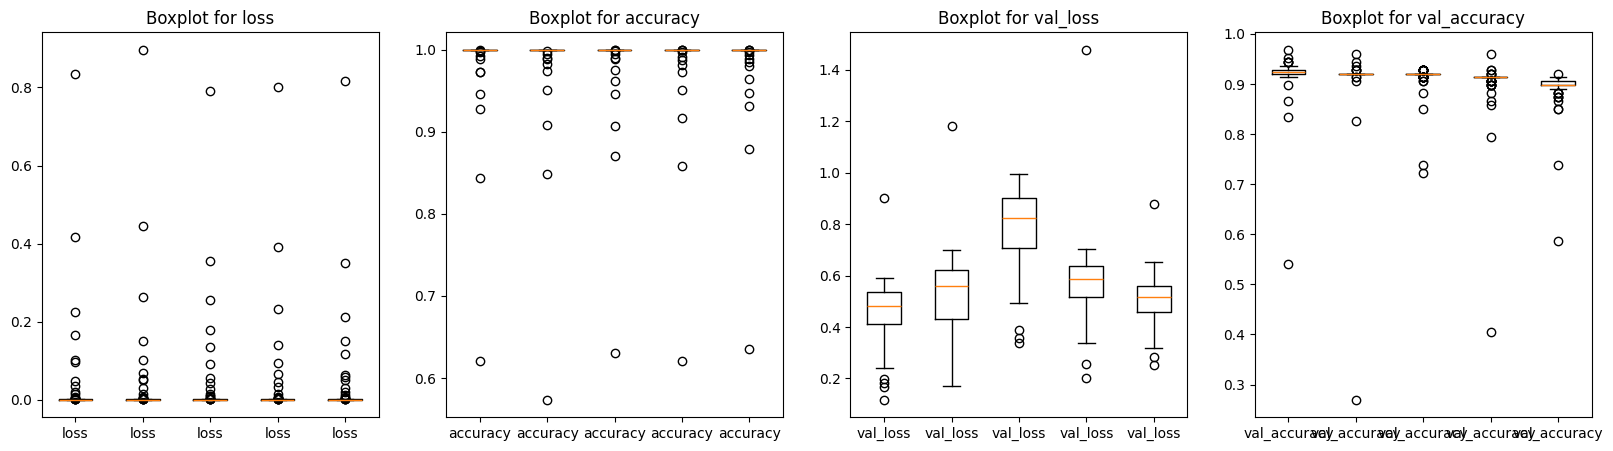

In [10]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt






train_dir = 'C:/Users/mitja/Desktop/podatki/train'
test_dir = 'C:/Users/mitja/Desktop/podatki/test'

class_indices = None

def create_dataframe(directory, is_test=False):
    filepaths = []
    labels = []
    if is_test:

        for file in os.listdir(directory):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(directory, file))
                labels.append(None)  
    else:
        categories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        for category in categories:
            cat_dir = os.path.join(directory, category)
            files = os.listdir(cat_dir)
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    filepaths.append(os.path.join(cat_dir, file))
                    labels.append(category)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

def build_cnn_model(input_shape, num_classes, filters=16, dense_neurons=128, learning_rate=0.001):
    model = Sequential([
        Conv2D(filters, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(filters, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(dense_neurons, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score(num_classes=3, average='macro')])
    return model

def train_model(model, train_generator, validation_generator, epochs=100):
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator
    )
    return history



def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

def compare_models(histories):
    val_accuracies = [max(history['val_accuracy']) for history in histories]
    best_model_index = np.argmax(val_accuracies)
    return best_model_index

def evaluate_model(model, test_generator):
    results = model.evaluate(test_generator)
    print(f'Test Results: {results}')
    return results

def save_predictions(model, test_generator, class_indices, file_name='submission.csv'):
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    labels = dict((v,k) for k,v in class_indices.items())
    predictions_labels = [labels[k] for k in predicted_classes]
    filenames = test_generator.filenames
    results = pd.DataFrame({"Filename": filenames, "Predictions": predictions_labels})
    results.to_csv(file_name, index=False)

def calculate_average_scores(histories):
    average_scores = {}
    for metric in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
        average_scores[metric] = np.mean([history[metric] for history in histories], axis=0)
    return average_scores

def plot_boxplots_for_metrics(histories):
    metrics = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
    data_to_plot = {metric: [] for metric in metrics}

    for history in histories:
        for metric in metrics:
            data_to_plot[metric].append(history[metric])
    
    fig, axs = plt.subplots(1, len(metrics), figsize=(20, 5))
    for i, metric in enumerate(metrics):
        metric_data = [history[metric] for history in histories]
        axs[i].boxplot(metric_data, labels=[metric] * len(histories))
        axs[i].set_title(f'Boxplot for {metric}')
    plt.show()

def main():
    global class_indices
    train_df = create_dataframe(train_dir, is_test=False)
    test_df = create_dataframe(test_dir, is_test=True)

    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    histories = []

    best_val_accuracy = 0 
    best_model = None  
    best_fold = 0  

    for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
        print(f"Training fold {fold+1}...")
        training_data = train_df.iloc[train_index]
        validation_data = train_df.iloc[val_index]

        train_generator = train_datagen.flow_from_dataframe(
            dataframe=training_data,
            x_col='filepath',
            y_col='label',
            target_size=(100, 100),
            color_mode='grayscale',
            batch_size=32,
            class_mode='categorical',
            subset='training',
            shuffle=True,
            seed=1234
        )

        validation_generator = train_datagen.flow_from_dataframe(
            dataframe=validation_data,
            x_col='filepath',
            y_col='label',
            target_size=(100, 100),
            color_mode='grayscale',
            batch_size=32,
            class_mode='categorical',
            subset='validation',
            shuffle=True,
            seed=1234
        )

        model = build_cnn_model((100, 100, 1), 3, filters=16, dense_neurons=128, learning_rate=0.001)
        history = model.fit(
            train_generator,
            epochs=100,
            validation_data=validation_generator
        )

        histories.append(history.history)

        val_accuracy = max(history.history['val_accuracy'])
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            best_fold = fold + 1


        if fold == 0:
            class_indices = train_generator.class_indices

    # Shranjevanje najboljšega modela
    best_model_path = 'best_cnn_model.h5'
    best_model.save(best_model_path)
    print(f"Najboljši model (fold {best_fold}) shranjen kot '{best_model_path}'.")

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepath',
        target_size=(100, 100),
        color_mode='grayscale',
        batch_size=1,
        class_mode=None,
        shuffle=False
    )

    best_model = load_model(best_model_path)
    evaluate_model(best_model, test_generator)

    save_predictions(best_model, test_generator, class_indices, file_name='kaggle_submission.csv')

    average_scores = calculate_average_scores(histories)
    print("Povprečne vrednosti metrik:")
    for metric, averages in average_scores.items():
        print(f"{metric}: {np.mean(averages)}")

    plot_boxplots_for_metrics(histories)

if __name__ == "__main__":
    main()
